In [1]:
import os
import cv2
import numpy as np
import pandas as pd

def load_images_and_labels(data_folder, df):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        image_filename = row['image']
        image_path = os.path.join(data_folder, image_filename)
        
        if not os.path.exists(image_path):
            print(f"Error: File '{image_filename}' not found in '{data_folder}'")
            continue
        
        label = row['number']
        
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error: Unable to read image '{image_filename}'")
            continue
        
        img = cv2.resize(img, (28, 28))
        
        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# مسیر پوشه‌های داده
train_folder = '/kaggle/input/persian-mnist/train'
test_folder = '/kaggle/input/persian-mnist/test'

# خواندن فایل‌های CSV
train_csv_path = '/kaggle/input/persian-mnist/train/train.csv'
test_csv_path = '/kaggle/input/persian-mnist/test/test.csv'

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# تابع خواندن تصاویر و برچسب‌ها از داده‌های آموزش و تست
train_images, train_labels = load_images_and_labels(train_folder, train_df)
test_images, test_labels = load_images_and_labels(test_folder, test_df)

# چاپ ابعاد تصاویر آموزش و تست
print("Train Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)


Train Images Shape: (60000, 28, 28)
Test Images Shape: (10000, 28, 28)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# جدا کردن داده‌های آموزش به داده‌های آموزش و ارزیابی
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# ایجاد یک مدل Sequential
model = models.Sequential()

# افزودن لایه Convolutional با 32 فیلتر 3x3 و تابع فعال‌سازی ReLU
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

# افزودن لایه MaxPooling با اندازه 2x2
model.add(layers.MaxPooling2D((2, 2)))

# افزودن لایه Convolutional با 64 فیلتر 3x3 و تابع فعال‌سازی ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# افزودن لایه MaxPooling با اندازه 2x2
model.add(layers.MaxPooling2D((2, 2)))

# افزودن لایه Convolutional با 64 فیلتر 3x3 و تابع فعال‌سازی ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# تبدیل ماتریس به یک بردار یکبعدی
model.add(layers.Flatten())

# افزودن لایه Dense با 64 نورون و تابع فعال‌سازی ReLU
model.add(layers.Dense(64, activation='relu'))

# افزودن لایه Dense با 10 نورون و تابع فعال‌سازی softmax (برای مسائل چند کلاسه)
model.add(layers.Dense(10, activation='softmax'))

# کامپایل مدل با تابع هزینه و بهینه‌ساز Adam
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# نمایش اطلاعات مدل
model.summary()

# آموزش مدل با داده‌های آموزش و ارزیابی
history = model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=20, validation_data=(validation_images.reshape(-1, 28, 28, 1), validation_labels))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

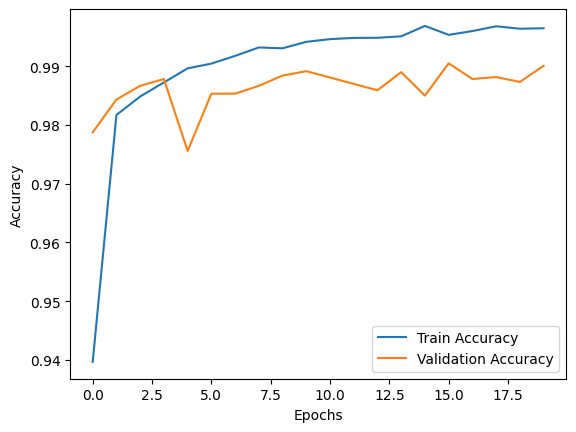

In [6]:
# نمایش نمودار دقت در طول زمان
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# ارزیابی مدل با داده‌های تست
test_loss, test_accuracy = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels)
print(f'Accuracy test: {test_accuracy}')

313/313 [==============================] - 1s 3ms/step - loss: 0.1158 - accuracy: 0.9868
Accuracy test: 0.9868000149726868


1/1 [==============================] - 0s 19ms/step


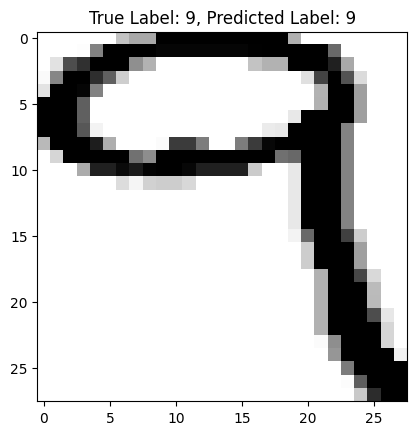

In [12]:
import random

# تصویر تصادفی از داده‌های تست را انتخاب کنید
random_index = random.randint(0, len(test_images) - 1)
random_image = test_images[random_index]
random_label = test_labels[random_index]

# تغییر اندازه تصویر به ابعاد موردنیاز برای ورود به مدل
input_image = cv2.resize(random_image, (28, 28))
input_image = input_image.reshape(1, 28, 28, 1)

# پیش‌بینی مدل روی تصویر تصادفی انتخاب شده
predicted_label = np.argmax(model.predict(input_image))

# نمایش تصویر
plt.imshow(random_image, cmap='gray')
plt.title(f"True Label: {random_label}, Predicted Label: {predicted_label}")
plt.show()

In [14]:
# ذخیره مدل به فرمت native Keras
model.save('my_model')
